In [1]:
import matplotlib.pyplot as plt
import pandas as pd

### With 100 points, three cases:

1. Ideal
2. Gaussian noise
3. Uniform noise

we have created a dataset with 100 points, with 5 features each. The relation we want to investigate is

$$
2.5382 cos(x_3)+x_0^2-0.5
$$

In [2]:
import numpy as np

X = 5 * np.random.randn(100, 5)
a = 0.5 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5 
n = y + a*np.random.randn(100,1)
u = y + a*np.random.rand(100,1)

from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    procs=8,
)

In [3]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "sin",
        "exp",
    ],
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    procs=8,
)

## 1. Ideal


In [4]:
model.fit(X, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 1.760e+05
Head worker occupation: 10.2%
Progress: 397 / 600 total iterations (66.167%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.806e+02  1.793e-07  23.570692
3           3.422e+00  2.646e+00  (x0 * x0)
5           3.052e+00  5.720e-02  ((x0 * x0) + -0.60814166)
6           1.441e+00  7.506e-01  ((x0 * x0) + cos(x3))
8           2.491e-01  8.774e-01  ((x0 * x0) + (cos(x3) * 2.5696905))
9           2.491e-01  1.717e-04  ((x0 * x0) + (cos(x3) * exp(0.95256466)))
10          3.322e-02  2.015e+00  (((x0 * x0) + (cos(x3) * 2.5696905)) + -0.6796174)
11          2.274e-03  2.682e+00  (((x0 * x0) + (cos(x3) * exp(0.95256466))) + -0.4679447)
12          5.698e-12  1.977e+01  (((x0 * x0) + (cos(x3) * 2.5382)) + (0.33066484 + -0.83066463)...
                                  )
---------------------------------------------------

PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                          23.570692   
	1         2.646407                                          (x0 * x0)   
	2         0.057198                          ((x0 * x0) + -0.60814166)   
	3         0.750635                              ((x0 * x0) + cos(x3))   
	4         0.877432                ((x0 * x0) + (cos(x3) * 2.5696905))   
	5         0.000172          ((x0 * x0) + (cos(x3) * exp(0.95256466)))   
	6         3.122881  (((x0 * x0) + (cos(x3) * 2.5696905)) + -0.6011...   
	7         1.573436  (((x0 * x0) + (cos(x3) * exp(0.95256466))) + -...   
	8  >>>>  19.804691  (((x0 * x0) + (cos(x3) * 2.5382)) + (0.3306648...   
	
	           loss  complexity  
	0  6.805666e+02           1  
	1  3.421609e+00           3  
	2  3.051749e+00           5  
	3  1.440630e+00           6  
	4  2.491294e-01           8  
	5  2.490867e-01           9  
	6  1.096732e-02          10  
	7  2.273871e-03          11  
	8  5.697673e-12          12  
]

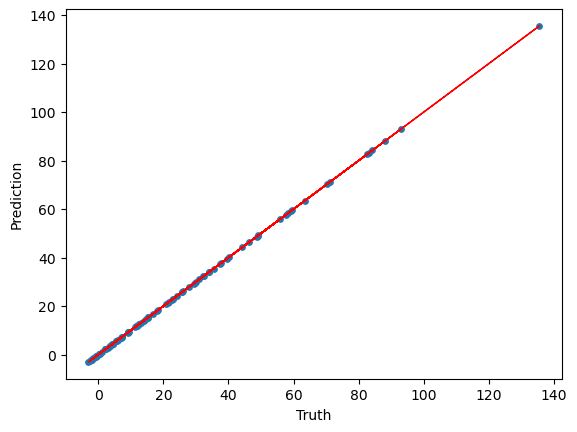

In [5]:
plt.scatter(y, model.predict(X),s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [6]:
model.latex()

'x_{0}^{2} + 2.54 \\cos{\\left(x_{3} \\right)} - 0.500'

$$ 'x_{0}^{2} + 2.70\cos{\left(x_{3} \right)} - 0.546' $$
seems good

## 2. Gaussian noise


In [7]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1773: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Milan, we have some problems with the gaussian noise